In [23]:
# Setting up local dataset paths - no need for Google Drive since we have the data locally
# SMIDS dataset path
SMIDS_PATH = r"C:\Users\rosel\Downloads\Sperm Project_Group 3\SMIDS-20250630T085408Z-1-001\SMIDS"
# HuSHeM dataset path  
HUSHEM_PATH = r"C:\Users\rosel\Downloads\Sperm Project_Group 3\HuSHeM-20250630T085035Z-1-001\HuSHeM"

In [24]:
# Installing specific TensorFlow version if needed (currently commented out)
#!pip install tensorflow==1.14.0
import tensorflow as tf

In [25]:
# Importing all the libraries we need for the deep learning model
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam, Adamax, Nadam, RMSprop, Adagrad, Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, SeparableConv2D, BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten  
import numpy as np
import skimage.io as io
from skimage.transform import resize
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import itertools  

In [41]:
# Configuration parameters for our model training

file_structure='Original' # Could be 'Folded' but we're using 'Original'
#####
batch_size=16  # Number of samples processed before updating the model
#####
epochs=10  # Number of complete passes through the training dataset
#####
augment=4  # Data augmentation multiplier
#####
img_size=170  # Input image size (170x170 pixels)
##########
# Data augmentation parameters
r_r=20         # Rotation range
z_r=0.15       # Zoom range
w_s_r=0.2      # Width shift range
h_s_r=0.2      # Height shift range
s_r=0.15       # Shear range
h_f=True       # Horizontal flip
f_m="nearest"  # Fill mode
########
input_size=3   # RGB channels (3 for color images)
########
weight='imagenet'  # Pre-trained weights
#weight=None

####
lr=0.0001  # Learning rate (reduced for better stability)
####
a='softmax'  # Activation function options: 'softmax', 'softplus', 'hard_sigmoid','sigmoid'
####
o='adam'      # Optimizer options: 'adam', 'adamax','sgd' (changed to adam for better performance)
####
mdl='Xception'  # Model architecture: Xception-InceptionV3-MobileNet-MobileNetV2-VGG16-VGG19-ResNet-ResNetV2-InceptionResNetV2-DenseNet-NASnet

In [27]:
mainPath = HUSHEM_PATH

In [28]:
os.chdir(mainPath)

In [29]:
# Make sure we're in the main dataset directory
os.chdir(mainPath)
folds = sorted([item for item in os.listdir() if os.path.isdir(item) and item.startswith('fold')])

# Go to the first fold's train directory to get class names
train_dir = os.path.join(mainPath, folds[0], 'train')
train_items = os.listdir(train_dir)

# Filter to only get actual class directories (not files like .json, .h5, etc.)
classes = sorted([item for item in train_items if os.path.isdir(os.path.join(train_dir, item)) and not item.startswith('.')])
numberOfFiles = len(classes)

print(f"Available folds: {folds}")
print(f"Found {numberOfFiles} class directories: {classes}")

# Stay in mainPath for data processing
os.chdir(mainPath)

Available folds: ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
Found 4 class directories: ['01_Normal', '02_Tapered', '03_Pyriform', '04_Amorphous']


In [30]:
# Using one-hot encoding to represent the classes as binary vectors
def one_hot_encode(labels):
    encoded = np.zeros((len(labels), numberOfFiles))
    for idx, val in enumerate(labels):
        encoded[idx][val] = 1
    return encoded

In [31]:
# Data preparation function
# v = fold (fold1-fold2-fold3-fold4-fold5)
# type = Train/Test
def data_prep(v,type):
    train_labels=[]
    image_dataset=[]
    print(f"Classes found: {classes}")
    print(f"Looking for data in: {mainPath}/{v}/{type}/")
    
    for j, k in enumerate(classes):     
      directory = os.path.join(mainPath, v, type, k)
      print(f"Checking directory: {directory}")
      
      # Check if directory exists
      if not os.path.exists(directory):
          print(f"WARNING: Directory does not exist: {directory}")
          continue
          
      # Check if directory has files
      try:
          class_names = next(os.walk(directory))
          file_list = class_names[2]  # Get list of files
          print(f"{directory} -> {len(file_list)} files found.")
          
          if len(file_list) == 0:
              print(f"WARNING: No files found in {directory}")
              continue
              
      except StopIteration:
          print(f"ERROR: Cannot access directory {directory}")
          continue
          
      # Process files in the directory
      for cs in file_list:
        try:
            path = os.path.join(directory, cs)
            #print(path)
            img = io.imread(path)
            img = resize(img, (img_size, img_size, input_size), anti_aliasing=True)
            image_dataset.append(img)
            train_labels.append(j)
        except Exception as e:
            print(f"Error reading image {path}: {e}")
            continue
            
    image_dataset = np.asarray(image_dataset)
    
    if len(image_dataset) == 0:
        print(f"ERROR: No images loaded for {type} data!")
        return None, None
        
    encoded = one_hot_encode(train_labels)
    print(f'{type} data read successfully. Total images: {len(image_dataset)}')
    return image_dataset, encoded

In [32]:
# Function to set up different optimizers with learning rate
# Available options: 'rmsprop','adagrad', 'nadam','adadelta' 'adam','adamax', 'SGD'
def rate_opt(opt,lr):
  try:
    if(opt=='SGD'):
      from tensorflow.keras.optimizers import SGD
      optim=SGD(learning_rate=lr)
    elif(opt=='RMSprop'):
      from tensorflow.keras.optimizers import RMSprop
      optim=RMSprop(learning_rate=lr)
    elif(opt=='Adagrad'):
      from tensorflow.keras.optimizers import Adagrad
      optim=Adagrad(learning_rate=lr)
    elif(opt=='Nadam'):
      from tensorflow.keras.optimizers import Nadam
      optim=Nadam(learning_rate=lr)
    elif(opt=='Adadelta'):
      from tensorflow.keras.optimizers import Adadelta
      optim=Adadelta(learning_rate=lr)
    elif(opt=='Adamax'):
      from tensorflow.keras.optimizers import Adamax
      optim=Adamax(learning_rate=lr)
    else: 
      from tensorflow.keras.optimizers import Adam
      optim=Adam(learning_rate=lr)
  except:
    print('An exception occurred from learning rate value step!!! Please check your input like 0.1--0.01--0.0001')

  return optim

In [33]:
# Creating the model from scratch using pre-trained networks
def mdlcmp(opt,act):
  # Setting up the base model architecture
  if(mdl=='MobileNet'):
    from tensorflow.keras.applications.mobilenet import MobileNet
    from tensorflow.keras.applications.mobilenet import preprocess_input
    base_model = MobileNet(weights=weight, include_top=False, input_shape=(img_size, img_size, 3))
  elif(mdl=='Xception'):
    from tensorflow.keras.applications.xception import Xception
    from tensorflow.keras.applications.xception import  preprocess_input 
    base_model = Xception(weights=weight, include_top=False, input_shape=(img_size, img_size, 3))
  elif(mdl=='VGG16'):
    from tensorflow.keras.applications.vgg16 import VGG16
    from tensorflow.keras.applications.vgg16 import preprocess_input
    base_model = VGG16(weights=weight, include_top=False, input_shape=(img_size, img_size, 3))
  elif(mdl=='VGG19'):
    from tensorflow.keras.applications.vgg19 import VGG19
    from tensorflow.keras.applications.vgg19 import preprocess_input
    base_model = VGG19(weights=weight, include_top=False, input_shape=(img_size, img_size, 3))
  elif(mdl=='ResNet'):
    from tensorflow.keras.applications.resnet import ResNet152
    from tensorflow.keras.applications.resnet import preprocess_input
    base_model = ResNet152(weights=weight, include_top=False, input_shape=(img_size, img_size, 3))
  elif(mdl=='ResNetV2'):
    from tensorflow.keras.applications.resnet_v2 import ResNet152V2
    from tensorflow.keras.applications.resnet_v2 import preprocess_input
    base_model = ResNet152V2(weights=weight, include_top=False, input_shape=(img_size, img_size, 3))
  elif(mdl=='InceptionResNetV2'):
    from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
    from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
    base_model = InceptionResNetV2(weights=weight, include_top=False, input_shape=(img_size, img_size, 3))
  elif(mdl=='MobileNetV2'):
    from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    base_model = MobileNetV2(weights=weight, include_top=False, input_shape=(img_size, img_size, 3))
  elif(mdl=='DenseNet'):
    from tensorflow.keras.applications.densenet import DenseNet201
    from tensorflow.keras.applications.densenet import preprocess_input
    base_model = DenseNet201(weights=weight, include_top=False, input_shape=(img_size, img_size, 3))
  elif(mdl=='NASnet'):
    from tensorflow.keras.applications.nasnet import NASNetLarge
    from tensorflow.keras.applications.nasnet import preprocess_input
    base_model = NASNetLarge(weights=weight, include_top=False, input_shape=(img_size, img_size, 3))
  else:
    from tensorflow.keras.applications.inception_v3 import InceptionV3
    from tensorflow.keras.applications.inception_v3 import preprocess_input
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
  
  # Adding our custom layers for classification
  x = base_model.output
  x = Flatten()(x)
  predictions = Dense(numberOfFiles, activation=act)(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  
  # Compiling the model with our chosen optimizer and loss function
  model.compile(optimizer=rate_opt(opt,lr),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  #callbacks_list = [keras.callbacks.EarlyStopping(monitor='acc', mode='max', patience=3, verbose=1)]
  return model

In [34]:
# Data augmentation parameters to artificially increase our dataset size
def datagen():
    datagen = ImageDataGenerator(
              rotation_range=r_r,
              zoom_range=z_r,
              width_shift_range=w_s_r,
              height_shift_range=h_s_r, 
              shear_range=s_r,
              horizontal_flip=h_f, 
              fill_mode=f_m)
    return datagen

In [35]:
##### TRAINING DATA SECTION #####

In [43]:
# Model training and saving results

scoreses=[]
mdls=[]
fds=['fold1']  # We can use all folds: ['fold1', 'fold2', 'fold3','fold4','fold5']

for i, v in enumerate(fds): # Reading fold by fold data
  # Displaying current training configuration
  print("!!!!!!!!!!!!!!! ",mdl,a,o,v+" training !!!!!!!!!!!!!!!!!!!") 
  print(f"Available folds: {folds}")
  
  # Preparing the training and test data   
  train, train_label = data_prep(v, 'train')
  if train is None:
      print(f"ERROR: Failed to load training data for {v}")
      continue
  print("Train data loaded successfully")
  
  test, test_label = data_prep(v, 'test')
  if test is None:
      print(f"ERROR: Failed to load test data for {v}")
      continue
  print("Test data loaded successfully")

  # Compiling the model 
  model = mdlcmp(o, a)    

  # Setting up data augmentation
  aug = datagen()
  epoch_step = ((len(train) * augment) // batch_size) + 1
  print('Steps per epoch:', epoch_step, ' Train length:', len(train))

  # Training the model (using modern fit method instead of deprecated fit_generator)
  history = model.fit(aug.flow(train, train_label, batch_size=batch_size),
                      steps_per_epoch=epoch_step,
                      epochs=epochs)                         
  
  # Testing the model performance
  print(a, o, 'TestFold {', i+1, '}')
  scores = model.evaluate(test, test_label, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1], '\n')
  
  # Saving the results
  scoreses.append(scores)
  print("Results so far:", scoreses)



!!!!!!!!!!!!!!!  Xception softmax adam fold1 training !!!!!!!!!!!!!!!!!!!
Available folds: ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
Classes found: ['01_Normal', '02_Tapered', '03_Pyriform', '04_Amorphous']
Looking for data in: C:\Users\rosel\Downloads\Sperm Project_Group 3\HuSHeM-20250630T085035Z-1-001\HuSHeM/fold1/train/
Checking directory: C:\Users\rosel\Downloads\Sperm Project_Group 3\HuSHeM-20250630T085035Z-1-001\HuSHeM\fold1\train\01_Normal
C:\Users\rosel\Downloads\Sperm Project_Group 3\HuSHeM-20250630T085035Z-1-001\HuSHeM\fold1\train\01_Normal -> 43 files found.
Checking directory: C:\Users\rosel\Downloads\Sperm Project_Group 3\HuSHeM-20250630T085035Z-1-001\HuSHeM\fold1\train\02_Tapered
C:\Users\rosel\Downloads\Sperm Project_Group 3\HuSHeM-20250630T085035Z-1-001\HuSHeM\fold1\train\02_Tapered -> 42 files found.
Checking directory: C:\Users\rosel\Downloads\Sperm Project_Group 3\HuSHeM-20250630T085035Z-1-001\HuSHeM\fold1\train\02_Tapered
C:\Users\rosel\Downloads\Sperm Project_G

c:\Users\rosel\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.2924 - loss: 1.5040
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.2924 - loss: 1.5040
Epoch 2/10


c:\Users\rosel\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


43/43 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6667 - loss: 0.8722 
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6667 - loss: 0.8722 
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8070 - loss: 0.5533 
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8070 - loss: 0.5533 
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8480 - loss: 0.3998 
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8480 - loss: 0.3998 
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8772 - loss: 0.3737 
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8772 - loss: 0.3737 
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9415 - loss: 0.1792 
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.9415 - loss: 0.1792 
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9415 - loss: 0.1791 
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9415 - loss:

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

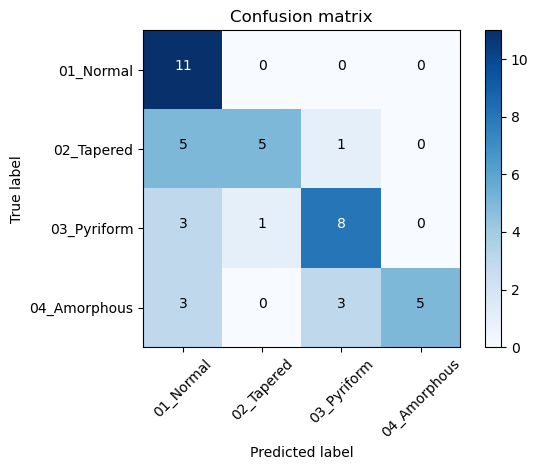

In [50]:
# Setting up class names for confusion matrix based on dataset
h="HuSHeM"
s="SMIDS"
dat=h
if(dat==s):
  class_names=['Acrosome Abnormality','Boya','Sperm'] # SMIDS classes
else:
  class_names=['01_Normal','02_Tapered','03_Pyriform','04_Amorphous'] # HuSHeM classes
  
# Generating predictions and creating confusion matrix
pred = model.predict(test,verbose=0)
y_pred = np.argmax(pred, axis=1)
y_test = np.argmax(test_label,axis=1)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cnf_matrix,classes=class_names,
                       normalize=False,
                       title='Confusion matrix', cmap=plt.cm.Blues)

In [51]:
# Saving the model to disk so we can use it in our interface later
model_json = model.to_json()

with open('mobil.json', 'w') as json_file:
    json_file.write(model_json)
# Serialize weights to HDF5 format (must end with .weights.h5)
save_location ="Mobil_Hushem.weights.h5"
model.save_weights(save_location)
print("Saved model to disk")

Saved model to disk


In [52]:
############################################
############################################
############################################
############################################
############################################

In [57]:
import os

########## TRANSFER LEARNING: Loading model weights and training on a different dataset ##########
json_path = os.path.join(HUSHEM_PATH, 'mobil.json')
print(f"Loading model JSON from: {json_path}")
json_file = open(json_path, 'r')
loaded_model_json = json_file.read()
json_file.close()

Loading model JSON from: C:\Users\rosel\Downloads\Sperm Project_Group 3\HuSHeM-20250630T085035Z-1-001\HuSHeM\mobil.json


In [54]:
import os

foldsa=['fold1'] # Available folds: ['fold1', 'fold2', 'fold3','fold4','fold5']
dat=s # Choose which dataset to use (s for SMIDS, h for HuSHeM)
augmenta=2

if(dat==s):
  #img_size=170  # Use 131 for HuSHeM, 170 for SMIDS
  CLASSES = 3 # HuSHeM has 4 classes, SMIDS has 3 classes
else:
  #img_size=131
  CLASSES = 4

# Update the main path based on which dataset we want to use
if(dat==s):
    mainPath = SMIDS_PATH  # Switch to SMIDS dataset
    print(f"Using SMIDS dataset at: {mainPath}")
else:
    mainPath = HUSHEM_PATH  # Keep using HuSHeM dataset
    print(f"Using HuSHeM dataset at: {mainPath}")

# Update the working directory and get class information
os.chdir(mainPath)
folds = sorted([item for item in os.listdir() if os.path.isdir(item) and item.startswith('fold')])
train_dir = os.path.join(mainPath, folds[0], 'train')
train_items = os.listdir(train_dir)
classes = sorted([item for item in train_items if os.path.isdir(os.path.join(train_dir, item)) and not item.startswith('.')])
numberOfFiles = len(classes)
print(f"Found {numberOfFiles} classes: {classes}")

Using SMIDS dataset at: C:\Users\rosel\Downloads\Sperm Project_Group 3\SMIDS-20250630T085408Z-1-001\SMIDS
Found 3 classes: ['Acrosome Abnormality', 'Boya', 'Sperm']


In [58]:
# Creating the model from our saved JSON file
loaded_model_1 = model_from_json(loaded_model_json)

# Loading the pre-trained weights (using correct path and .weights.h5 filename)
weights_path = os.path.join(HUSHEM_PATH, 'Mobil_Hushem.weights.h5')
print(f"Loading weights from: {weights_path}")
loaded_model_1.load_weights(weights_path)

Loading weights from: C:\Users\rosel\Downloads\Sperm Project_Group 3\HuSHeM-20250630T085035Z-1-001\HuSHeM\Mobil_Hushem.weights.h5


In [59]:
loaded_model_1.summary()
loaded_model_1.layers.pop()
loaded_model_1.layers.pop()
loaded_model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 170, 170,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 84, 84,    │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 84, 84,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 84, 84,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 82, 82,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 82, 82,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 82, 82,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 82, 82,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 82, 82,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 82, 82,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 82, 82,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 82, 82,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 41, 41,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 41, 41,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 41,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 41, 41,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 41, 41,    │          0 │ add_12[0][0]    

 Total params: 63,360,134 (241.70 MB)

 Trainable params: 21,101,868 (80.50 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 42,203,738 (160.99 MB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 170, 170,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 84, 84,    │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 84, 84,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 84, 84,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 82, 82,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 82, 82,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 82, 82,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 82, 82,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 82, 82,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 82, 82,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 82, 82,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 82, 82,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 41, 41,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 41, 41,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 41,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 41, 41,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 41, 41,    │          0 │ add_12[0][0]    

 Total params: 63,360,134 (241.70 MB)

 Trainable params: 21,101,868 (80.50 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 42,203,738 (160.99 MB)

In [61]:
# Get image size from the loaded model (updated for modern TensorFlow)
img_size = loaded_model_1.input.shape[1]  # Height dimension
print(f"Image size: {img_size}")
print(f"Input shape: {loaded_model_1.input.shape}")

Image size: 170
Input shape: (None, 170, 170, 3)


In [62]:
from tensorflow.keras.layers import Input, Flatten
#####
print('Step 1: Modifying the last layers')
x = Flatten()(loaded_model_1.layers[-1].output)
loaded_model_1.summary()
#####
print('Step 2: Adding new dense layer')
predictions = Dense(CLASSES, activation='sigmoid')(x)
loaded_model_1.summary()
#####
print('Step 3: Creating the final model')
loaded_model = Model(inputs=loaded_model_1.input, outputs=predictions)
loaded_model.summary()
print('Step 4: Model ready')
# Compiling the new model with different parameters
loaded_model.compile(loss="categorical_crossentropy",optimizer='adamax', metrics=['accuracy'])

Step 1: Modifying the last layers


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 170, 170,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 84, 84,    │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 84, 84,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 84, 84,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 82, 82,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 82, 82,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 82, 82,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 82, 82,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 82, 82,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 82, 82,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 82, 82,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 82, 82,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 41, 41,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 41, 41,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 41,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 41, 41,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 41, 41,    │          0 │ add_12[0][0]    

 Total params: 63,360,134 (241.70 MB)

 Trainable params: 21,101,868 (80.50 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 42,203,738 (160.99 MB)

Step 2: Adding new dense layer


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 170, 170,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 84, 84,    │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 84, 84,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 84, 84,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 82, 82,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 82, 82,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 82, 82,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 82, 82,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 82, 82,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 82, 82,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 82, 82,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 82, 82,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 41, 41,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 41, 41,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 41,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 41, 41,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 41, 41,    │          0 │ add_12[0][0]    

 Total params: 63,360,134 (241.70 MB)

 Trainable params: 21,101,868 (80.50 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 42,203,738 (160.99 MB)

Step 3: Creating the final model


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 170, 170,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 84, 84,    │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 84, 84,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 84, 84,    │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 82, 82,    │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 82, 82,    │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 82, 82,    │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 82, 82,    │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 82, 82,    │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 82, 82,    │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 82, 82,    │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 82, 82,    │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 41, 41,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 41, 41,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 41, 41,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 41, 41,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 41, 41,    │          0 │ add_12[0][0]    

 Total params: 21,156,411 (80.71 MB)

 Trainable params: 21,101,883 (80.50 MB)

 Non-trainable params: 54,528 (213.00 KB)

Step 4: Model ready


In [63]:
# Training the transfer learning model and saving results
scoresesa=[]
for i, v in enumerate(foldsa): # Reading fold by fold data: ['fold1', 'fold2', 'fold3','fold4','fold5']
  print(f'!!!!!!!!!!!!!!! FOLD-{i+1} TRAINING !!!!!!!!!!!!!!!!!!!')
  
  # Preparing the data   
  traina,train_labela=data_prep(v,'train')
  print('\nLoading test data\n')
  testa,test_labela=data_prep(v,'test')

  # Setting up data augmentation
  auga=datagen()
  epoch_step = ((len(traina) *  augmenta) // batch_size) + 1
  print('Steps per epoch:',epoch_step,' Train length:',len(traina))
 
  # Training the model (using modern fit method instead of deprecated fit_generator)
  history = loaded_model.fit(auga.flow(traina, train_labela, batch_size=batch_size),
                             steps_per_epoch=epoch_step,
                             epochs=epochs)      
                         
  # Testing the model performance
  print(a,o,'TestFold {',i+1,'}')
  scores = loaded_model.evaluate(testa,test_labela, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1],'\n')
  
  # Saving the results
  scoresesa.append(scores)

!!!!!!!!!!!!!!! FOLD-1 TRAINING !!!!!!!!!!!!!!!!!!!
Classes found: ['Acrosome Abnormality', 'Boya', 'Sperm']
Looking for data in: C:\Users\rosel\Downloads\Sperm Project_Group 3\SMIDS-20250630T085408Z-1-001\SMIDS/fold1/train/
Checking directory: C:\Users\rosel\Downloads\Sperm Project_Group 3\SMIDS-20250630T085408Z-1-001\SMIDS\fold1\train\Acrosome Abnormality
C:\Users\rosel\Downloads\Sperm Project_Group 3\SMIDS-20250630T085408Z-1-001\SMIDS\fold1\train\Acrosome Abnormality -> 804 files found.
Checking directory: C:\Users\rosel\Downloads\Sperm Project_Group 3\SMIDS-20250630T085408Z-1-001\SMIDS\fold1\train\Boya
C:\Users\rosel\Downloads\Sperm Project_Group 3\SMIDS-20250630T085408Z-1-001\SMIDS\fold1\train\Boya -> 785 files found.
Checking directory: C:\Users\rosel\Downloads\Sperm Project_Group 3\SMIDS-20250630T085408Z-1-001\SMIDS\fold1\train\Boya
C:\Users\rosel\Downloads\Sperm Project_Group 3\SMIDS-20250630T085408Z-1-001\SMIDS\fold1\train\Boya -> 785 files found.
Checking directory: C:\Users\

c:\Users\rosel\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
151/301 ━━━━━━━━━━━━━━━━━━━━ 16:55 7s/step - accuracy: 0.4292 - loss: 0.9868

c:\Users\rosel\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


301/301 ━━━━━━━━━━━━━━━━━━━━ 1067s 3s/step - accuracy: 0.5135 - loss: 0.9437
Epoch 2/10
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 928s 3s/step - accuracy: 0.7185 - loss: 0.8711 
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 928s 3s/step - accuracy: 0.7185 - loss: 0.8711 
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 1266s 4s/step - accuracy: 0.7443 - loss: 0.8325
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 1266s 4s/step - accuracy: 0.7443 - loss: 0.8325
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 998s 3s/step - accuracy: 0.7933 - loss: 0.7772 
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 998s 3s/step - accuracy: 0.7933 - loss: 0.7772 
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 1151s 4s/step - accuracy: 0.7638 - loss: 0.7677
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 1151s 4s/step - accuracy: 0.7638 - loss: 0.7677
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 1129s 4s/step - accuracy: 0.7759 - loss: 0.7359
Epoch 7/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 1129s 4s/step - accuracy: 0.7759 - loss: 0.7359
Epoch 7/10
301/301 ━━━━━━━━━━━━━

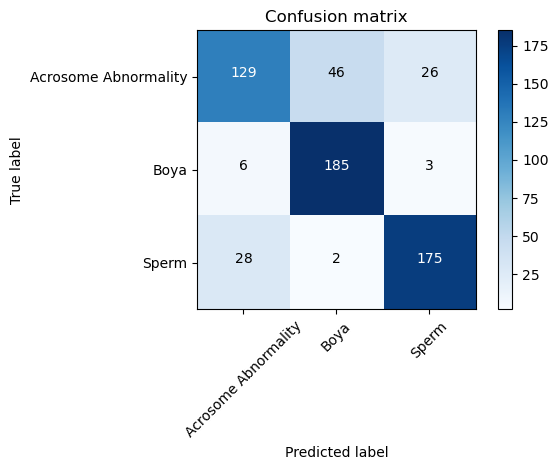

In [64]:
# Setting up class names for confusion matrix based on dataset
if(dat==s):
  class_names=['Acrosome Abnormality','Boya','Sperm'] # SMIDS classes
else:
  class_names=['01_Normal','02_Tapered','03_Pyriform','04_Amorphous'] # HuSHeM classes
  
# Generating predictions and creating confusion matrix
preda = loaded_model.predict(testa,verbose=0)
y_preda = np.argmax(preda, axis=1)
y_testa = np.argmax(test_labela,axis=1)
cnf_matrix = confusion_matrix(y_testa, y_preda)
plot_confusion_matrix(cnf_matrix,classes=class_names,
                       normalize=False,
                       title='Confusion matrix', cmap=plt.cm.Blues)